In [33]:
# 1/31/18 - attempting with full / actual data for final. -mt

### Step 3: Import libraries and modules

In [2]:
# importing numpy and setting a seed for reproductibility
import numpy as np
np.random.seed(123) # kinda irrelevant. not really using randomness. -mt

import os
from tqdm import tqdm
import pandas as pd

In [3]:
# importing standard keras modules/layers/utilities
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.


In [4]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

#### Building off of: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html -mt

Directory structure looks like:
```
catdog_small_training_dir/
    train/
        urban/
            *.jpg
            **.jpg
            ...
        nature/
            ***.jpg
            ****.jpg
            ...
    validation/
        urban/
            *.jpg
            **.jpg
            ...
        nature/
            ***.jpg
            ****.jpg
            ...
```            

### Step 4: Point to images for dataset creation (later)

In [6]:
# desired input dimensions.
img_width, img_height = 250, 250

train_data_dir = 'final_training_dir/train'
validation_data_dir = 'final_training_dir/validation'

In [7]:
# in the future, use a count function to determine below, instead of manually setting
nb_train_samples = 4084
nb_validation_samples = 1339

epochs = 30
batch_size = 32

In [8]:
# reshape array shapes as needed (tensorflow vs theano)
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### Step 5: Define model

In [9]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4)) # set number of final classes. -mt

# model.add(Activation('sigmoid')) #non-mutually exclusive
model.add(Activation('softmax')) #mutually exclusive

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 248, 248, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 248, 248, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 64)        18496     
__________

In [11]:
# tinkering with different optimizers, learning rates, and decay. -mt
# read more: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

# sgd = optimizers.SGD(lr=0.1)

learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

# adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [12]:
model.compile(#loss='sparse_categorical_crossentropy',
              loss='categorical_crossentropy',
#               loss='binary_crossentropy',
#               optimizer='rmsprop',
              optimizer='sgd',
              metrics=['accuracy'])

### Step 6: Data augmentation

In [13]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rotation_range=40,
    rescale=1. / 255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True)

In [14]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 4084 images belonging to 4 classes.


In [16]:
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1339 images belonging to 4 classes.


In [17]:
# which integer is which class
train_generator.class_indices

{'animal': 0, 'nature': 1, 'person': 2, 'urban': 3}

#### Test data augmentation

In [18]:
# img = load_img('/Users/minhgeneralassembly/Downloads/kaggle_catsanddogs/small_training_dir/train/cats/cat.0.jpg')  # this is a PIL image
# x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
# x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

In [19]:
# i = 0
# for batch in train_datagen.flow(x, batch_size=1,
#                           save_to_dir='/Users/minhgeneralassembly/Downloads/kaggle_catsanddogs/preview', save_prefix='cat', save_format='jpeg'):
#     i += 1
#     if i > 20:
#         break  # otherwise the generator would loop indefinitely

### Step 7: Fit model

In [20]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/30
  5/127 [>.............................] - ETA: 9:03 - loss: 1.3924 - acc: 0.2375

/Users/minhgeneralassembly/anaconda2/lib/python2.7/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


127/127 [==============================] - 465s 4s/step - loss: 1.3569 - acc: 0.3305 - val_loss: 1.3032 - val_acc: 0.3956
Epoch 2/30
127/127 [==============================] - 454s 4s/step - loss: 1.2709 - acc: 0.4103 - val_loss: 1.1844 - val_acc: 0.4705
Epoch 3/30
127/127 [==============================] - 456s 4s/step - loss: 1.2029 - acc: 0.4647 - val_loss: 1.2241 - val_acc: 0.4407
Epoch 4/30
127/127 [==============================] - 457s 4s/step - loss: 1.1528 - acc: 0.4918 - val_loss: 1.1353 - val_acc: 0.5027
Epoch 5/30
127/127 [==============================] - 461s 4s/step - loss: 1.1149 - acc: 0.5131 - val_loss: 1.0899 - val_acc: 0.5233
Epoch 6/30
127/127 [==============================] - 463s 4s/step - loss: 1.0898 - acc: 0.5311 - val_loss: 1.0920 - val_acc: 0.5394
Epoch 7/30
127/127 [==============================] - 462s 4s/step - loss: 1.0778 - acc: 0.5451 - val_loss: 1.0711 - val_acc: 0.5218
Epoch 8/30
127/127 [==============================] - 469s 4s/step - loss: 1.045

### Step 7.5: Save model

In [21]:
import datetime

In [27]:
model.save(str(datetime.date.today()).replace("-","") + '_final_30epochs.h5')
# model.save('catsndogs_' + str(datetime.date.today()).replace("-","") + '.h5')

### Step 7.9: Reload model (if needed)

In [28]:
# model = load_model('catsndogs.h5')

### Step 8: Evaluate model

In [29]:
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


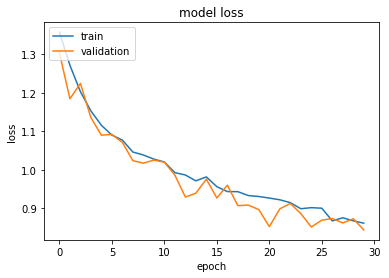

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

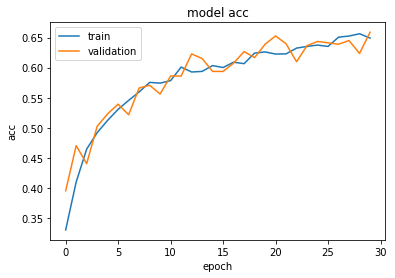

In [35]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
break

### Step 10: Compare test images vs predicted classes

In [43]:
def cropResizeImages(img):
    width, height = img.size

    if width > height:
        left = (width - height)/2
        top = (height - height)/2
        right = (width + height)/2
        bottom = (height + height)/2
        
        img = img.crop((left, top, right, bottom))
        img = img.resize([img_width,img_height])
        
    elif width == height:
        left = (width - height)/2
        top = (height - height)/2
        right = (width + height)/2
        bottom = (height + height)/2
        
        img = img.crop((left, top, right, bottom))
        img = img.resize([img_width,img_height])
    
    elif height > width:
        left = (width - width)/2
        top = (height - width)/2
        right = (width + width)/2
        bottom = (height + width)/2
        
        img = img.crop((left, top, right, bottom))
        img = img.resize([img_width,img_height])
        
    return img

In [44]:
# taken from lesson 17 + tinkering. -mt

In [45]:
test_img_dir = "final_testing_dir/" # actual testing directory

test_images = [test_img_dir + f for f in os.listdir(test_img_dir) if f.endswith('.jpg')]

In [46]:
test_images[0]

'final_testing_dir/1581371490_0e20ce0abb.jpg'

In [47]:
test_data = []

for test_image in tqdm(test_images):
    img = load_img(test_image)
    img = cropResizeImages(img)
    img = np.array(img)
    test_data.append(img)

100%|██████████| 131/131 [00:00<00:00, 167.29it/s]


In [88]:
df = pd.DataFrame(test_images, columns=['image_name'])

df['image'] = df['image_name'].map(lambda x: '<img src="{}" style="max-height: 300px; max-width: 300px;" ></img>'.format(x) )

In [89]:
df['predict_class'] = ''

for i,each in tqdm(df.iterrows()):
    each['predict_class'] = model.predict_classes(test_data[i][np.newaxis, :, :, :])

131it [00:05, 24.38it/s]


In [90]:
train_generator.class_indices

{'animal': 0, 'nature': 1, 'person': 2, 'urban': 3}

In [91]:
# todo: loop through train_generator.class_indices and make the below automatic/scalable. -mt

df['predict_name'] = ''

for i,each in tqdm(df.iterrows()):
    if each['predict_class'] == ([0]):
        each['predict_name'] = 'animal'
    elif each['predict_class'] == ([1]):
        each['predict_name'] = 'nature'
    elif each['predict_class'] == ([2]):
        each['predict_name'] = 'person'
    elif each['predict_class'] == ([3]):
        each['predict_name'] = 'urban'

131it [00:00, 3130.15it/s]


In [92]:
from IPython.display import HTML

In [93]:
pd.set_option('max_colwidth', 300)
HTML(df.to_html(escape=False))

,image_name,image,predict_class,predict_name
0,final_testing_dir/1581371490_0e20ce0abb.jpg,,[3],urban
1,final_testing_dir/4048396736_481fa86fbf.jpg,,[2],person
2,final_testing_dir/317103720_0c9d8384b1.jpg,,[2],person
3,final_testing_dir/2185120496_9c543f6196.jpg,,[3],urban
4,final_testing_dir/4117718041_5a6295c543.jpg,,[3],urban
5,final_testing_dir/355922840_270440cb22.jpg,,[2],person
6,final_testing_dir/zwijn-wild01.jpg,,[0],animal
7,final_testing_dir/2702247832_43ce9e399e.jpg,,[3],urban
8,final_testing_dir/4368083778_8b9fe62c1a.jpg,,[2],person
9,final_testing_dir/3090992202_b87f3eb479.jpg,,[2],person


In [95]:
df['predict_name'].value_counts()

person    69
urban     29
nature    17
animal    16
Name: predict_name, dtype: int64

In [ ]:
break

### Retrain model as needed
10 more epochs

In [83]:
del model

In [84]:
model = load_model('20180201_final_30epochs.h5')

In [86]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
127/127 [==============================] - 476s 4s/step - loss: 0.8486 - acc: 0.6616 - val_loss: 0.9091 - val_acc: 0.6166
Epoch 2/10
127/127 [==============================] - 457s 4s/step - loss: 0.8491 - acc: 0.6596 - val_loss: 0.8893 - val_acc: 0.6404
Epoch 3/10
127/127 [==============================] - 457s 4s/step - loss: 0.8564 - acc: 0.6530 - val_loss: 0.8253 - val_acc: 0.6634
Epoch 4/10
127/127 [==============================] - 465s 4s/step - loss: 0.8350 - acc: 0.6759 - val_loss: 0.8462 - val_acc: 0.6534
Epoch 5/10
127/127 [==============================] - 466s 4s/step - loss: 0.8360 - acc: 0.6677 - val_loss: 0.8443 - val_acc: 0.6603
Epoch 6/10
127/127 [==============================] - 468s 4s/step - loss: 0.8242 - acc: 0.6698 - val_loss: 0.8390 - val_acc: 0.6580
Epoch 7/10
127/127 [==============================] - 470s 4s/step - loss: 0.8225 - acc: 0.6709 - val_loss: 0.8448 - val_acc: 0.6572
Epoch 8/10
127/127 [==============================] - 470s 4s/step - 

In [87]:
model.save(str(datetime.date.today()).replace("-","") + '_final_40epochs.h5')